In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.Transformer.KernelAttention import LinearKernelAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=30, delta=0)

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# attention module
_attention = LinearKernelAttention()

# meta data to store images
FOLDER = "linear_kernel"
KERNEL_NAME = "linear"

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

In [9]:
seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

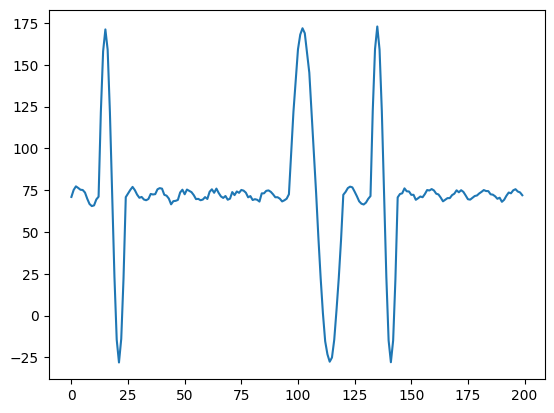

In [12]:
plt.plot(dataset.fX[:200])

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from src.Datasets.SyntheticPeriodicCurvesDataset import PeriodicCurvesDataset

total_length = 6000

A1, A2, A3 = np.array([[5], [100], [3]])
A4 = np.maximum(A1, A2)

data = PeriodicCurvesDataset.load_univariate(len_timeseries=total_length, A1=5, A2=100, A3=3)


In [5]:
data.ids.shape, data.values.shape, data.dates.shape

((1,), (1, 6000), (6000,))

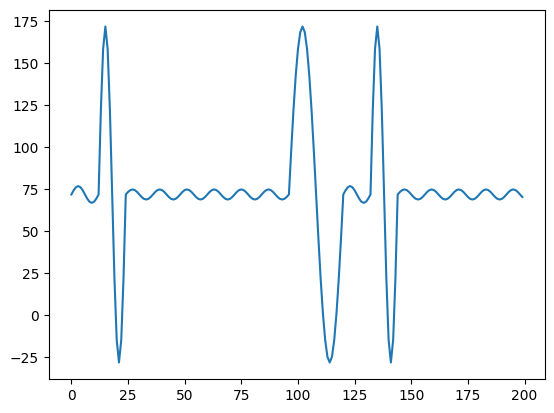

In [6]:
plt.plot(data.values[0, :200])

In [8]:
from src.Datasets.TrafficDataset import TrafficDataset

d = TrafficDataset.load()

d.dates.shape, d.values.shape, d.ids.shape

((10560,), (963, 10560), (963,))

In [7]:
A1, A2, A3 = np.random.rand(3, 8, 1) * 60
A4 = np.maximum(A1, A2)

A1.shape, A2.shape, A3.shape

((8, 1), (8, 1), (8, 1))

In [9]:
X = np.arange(0, total_length, dtype=np.float32)

c1 = A1 * np.sin(np.pi * X[None, :12] / 6) + 72
c2 = A2 * np.sin(np.pi * X[None, 12:24] / 6) + 72
c3 = A3 * np.sin(np.pi * X[None, 24:96] / 6) + 72
c4 = A4 * np.sin(np.pi * X[None, 96:120] / 12) + 72

fX = np.concatenate([c1, c2, c3, c4], axis=-1) # concat components
fX = fX.repeat((total_length + 120) // 120, axis=-1) # periodic repeats
fX = fX[:, :total_length]  # constrain total length
fX = fX + np.random.randn(*fX.shape)  # add noise


X.shape, fX.shape, A1.shape


((6000,), (8, 6000), (8, 1))

In [38]:
a = np.concatenate([c1, c2, c3, c4], axis=-1)
b = np.tile(a, (total_length + 120) // 120)
a.shape, b.shape

((1, 120), (1, 6120))